# Preprocessing

### install libraries

In [ ]:
!C:\Users\mehti\AppData\Local\Programs\Python\Python312\Scripts\pip install splitfolders

^C


### import libraries

In [1]:
import pandas as pd 
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
import zipfile
from typing import Tuple, Dict, List
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
import PIL
from torchvision import transforms
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader
import shutil
import splitfolders
pathlib.Path('models').mkdir(parents=True, exist_ok=True) 
pathlib.Path('plots').mkdir(parents=True, exist_ok=True)
%matplotlib inline 

### Dataset divide to class Folders

In [ ]:



dataset_path = "C:\LMU\python/SEP_DLCV/Github/SEP-CVDL-main/archive/RAF-DB/train"
csv_file_path = ""
destination_folder = ""

# Replace 'data.csv' with the actual filename of your CSV file
data = pd.read_csv(csv_file_path)  # Use csv_file_path variable here
label_df = pd.DataFrame(data)

# Print column names to inspect the structure of the DataFrame
print(label_df.columns)

# create class directories
for label in label_df[str(data.columns[1])].unique().astype(str):  # Adjust column name here
    if not os.path.exists(os.path.join(destination_folder, label)):
        os.mkdir(os.path.join(destination_folder, label))

# set the destination target
label_df['path'] = label_df[str(data.columns[1])].astype(str) + os.path.sep + label_df[str(data.columns[0])]  # Adjust column names here

# copy or move files
for _, row in label_df.iterrows():
    source_path = os.path.join(dataset_path, row[str(data.columns[0])])  # Adjust column name here
    destination_path = os.path.join(destination_folder, row['path'])
    shutil.move(source_path, destination_path)

### Unzip dataset zipfile

In [31]:
dataset_dir = "C:/LMU/python/SEP_DLCV/Final_project/last_work"
file_name = 'data'
data_path = dataset_dir + '/' + file_name

with zipfile.ZipFile(str(data_path) + ".zip", 'r') as zip_ref:
    zip_ref.extractall(str(dataset_dir)+'/')


### Spliting dataset into training and testing class_folders

In [32]:
percentage = float(input("Enter percentage of training data? "))/100

output = f"{data_path}set"+f"\\{file_name}"

splitfolders.ratio(data_path, output=output, ratio=(percentage, (1 - percentage)/2 , (1 - percentage)/2), group_prefix=None, move=False)
# for info: ratio(train, valid, test)


Copying files: 63193 files [00:42, 1500.85 files/s]


### Training dataset processing

training dataset:
- open the input image
- detect the face in input image
- resize the images to 64x64
- save the image
- shape of training dataset
- calculating mean and standard deviation of the dataset

In [33]:

print('#'*51)
print('################## training data ##################')
print('#'*51)



def detect_crop_face(image):
    # Load the pre-trained Haar cascade classifier for face detection
    face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    
    # Detect faces in the image
    face = face_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
    
    # Draw rectangles around the detected faces
    for (x, y, w, h) in face:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 10)
        # Crop face region from the original image
        face_region = image[y:y+h, x:x+w]
    
    return face_region


#############################################################
#############################################################


train_DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/dataset/data/train"

class_labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

X_train, y_train = [], []
classes_count = 0 

for folder in os.listdir(train_DS_path):
    if folder in class_labels:
        print(folder)
        for img in os.listdir(os.path.join(train_DS_path, folder)):
            if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
                try:
                    to_append = cv2.imread(os.path.join(train_DS_path, folder, img))
                    #to_append = detect_crop_face(img) -> already done!
                    to_append = cv2.resize(to_append,(64,64))
                    X_train.append(to_append)
                    y_train.append(classes_count)
                except Exception as e: 
                    print(e)
        classes_count += 1

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

##########################################################

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(X_train)

for i in range(numSamples):
    im = np.array(X_train[i])
    im = im.astype(float) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for i in range(numSamples):
    im = np.array(X_train[i])
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += np.sum((im[:, :, j] - mean[j]) ** 2) / (im.shape[0] * im.shape[1])

std = np.sqrt(stdTemp/numSamples)

mean_train_ds = mean
std_train_ds = std
print("mean of dataset: ", mean_train_ds)
print("std of dataset: ",std_train_ds)


###################################################
################## training data ##################
###################################################
anger
disgust
fear
happiness
sadness
surprise
(44232, 64, 64, 3)
(44232,)
mean of dataset:  [0.49028466 0.50004115 0.52557415]
std of dataset:  [0.25342231 0.25065595 0.25534419]


Testing data:
- resize the images to 64x64
- number of testing data

In [34]:

print('#'*51)
print('################## testing data ##################')
print('#'*51)

test_DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/dataset/data/test"

X_test, y_test = [], []
classes_count = 0 

for folder in os.listdir(test_DS_path):
    if folder in class_labels:
        print(folder)
        for img in os.listdir(os.path.join(test_DS_path, folder)):
            if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
                try:
                    to_append = cv2.imread(os.path.join(test_DS_path, folder, img))
                    #to_append = detect_crop_face(img) -> already done!
                    to_append = cv2.resize(to_append,(64,64))
                    X_test.append(to_append)
                    y_test.append(classes_count)
                except Exception as e: 
                    print(e)
        classes_count += 1

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape)
print(y_test.shape)

##########################################################

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(X_test)

for i in range(numSamples):
    im = np.array(X_test[i])
    im = im.astype(float) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for i in range(numSamples):
    im = np.array(X_test[i])
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += np.sum((im[:, :, j] - mean[j]) ** 2) / (im.shape[0] * im.shape[1])

std = np.sqrt(stdTemp/numSamples)

mean_test_ds = mean
std_test_ds = std
print("mean of dataset: ", mean_test_ds)
print("std of dataset: ",std_test_ds)

###################################################
################## testing data ##################
###################################################
anger
disgust
fear
happiness
sadness
surprise
(9484, 64, 64, 3)
(9484,)
mean of dataset:  [0.48946178 0.49970398 0.52541884]
std of dataset:  [0.25311961 0.2500443  0.25432753]


Validation data:
- resize the images to 64x64
- number of Validation data

In [35]:

print('#'*51)
print('################## validation data ##################')
print('#'*51)

valid_DS_path = "C:/LMU/python/SEP_DLCV/Final_project/last_work/dataset/data/val"

X_valid, y_valid = [], []
classes_count = 0 

for folder in os.listdir(valid_DS_path):
    if folder in class_labels:
        print(folder)
        for img in os.listdir(os.path.join(valid_DS_path, folder)):
            if img.endswith('jpg') or img.endswith('jpeg') or img.endswith('png'):
                try:
                    to_append = cv2.imread(os.path.join(valid_DS_path, folder, img))
                    #to_append = detect_crop_face(img) -> already done!
                    to_append = cv2.resize(to_append,(64,64))
                    X_valid.append(to_append)
                    y_valid.append(classes_count)
                except Exception as e: 
                    print(e)
        classes_count += 1

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
print(X_valid.shape)
print(y_valid.shape)

##########################################################

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(X_valid)

for i in range(numSamples):
    im = np.array(X_valid[i])
    im = im.astype(float) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for i in range(numSamples):
    im = np.array(X_valid[i])
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += np.sum((im[:, :, j] - mean[j]) ** 2) / (im.shape[0] * im.shape[1])

std = np.sqrt(stdTemp/numSamples)

mean_valid_ds = mean
std_valid_ds = std
print("mean of dataset: ", mean_valid_ds)
print("std of dataset: ",std_valid_ds)


###################################################
################## validation data ##################
###################################################
anger
disgust
fear
happiness
sadness
surprise
(9477, 64, 64, 3)
(9477,)
mean of dataset:  [0.49000055 0.50016493 0.52555151]
std of dataset:  [0.25356773 0.25067056 0.25519796]


### Transformations and torchvision ImageFolder

In [36]:
from torchvision import datasets
from torch.utils.data import DataLoader


train_transform = transforms.Compose([ 
    #transforms.RandomResizedCrop(size=64,  scale=(0.1, 1.1), ratio=(0.75, 1.333)),
    transforms.Resize(size=(64, 64)),
    #transforms.Grayscale(),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train_ds, std=std_train_ds) 
])


test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_test_ds, std=std_test_ds)
])

valid_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_valid_ds, std=std_valid_ds)
])

train_data = datasets.ImageFolder(root=train_DS_path,
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=test_DS_path, 
                                 transform=test_transform)

valid_data = datasets.ImageFolder(root=valid_DS_path, 
                                  transform=valid_transform)


### Dataloader

In [37]:
# dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=16, 
                              num_workers=4, 
                              shuffle=True) 
img, label = next(iter(train_dataloader))
print(f"Train batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=8, 
                             num_workers=1, 
                             shuffle=False) 
img, label = next(iter(test_dataloader))
print(f"Test batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


valid_dataloader = DataLoader(dataset=valid_data, 
                             batch_size=8, 
                             num_workers=1, 
                             shuffle=False) 
img, label = next(iter(valid_dataloader))
print(f"Valid batch: Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Train batch: Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])
Test batch: Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])
Valid batch: Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


### Model

In [38]:

class EmotionsDetector(nn.Module):
    def __init__(self):
        super(EmotionsDetector, self).__init__()

        # 1st Convolutional layer
        self.conv1_1 = nn.Conv2d(3, 48, kernel_size=(3, 3), padding=1)
        self.bn1_1 = nn.BatchNorm2d(48)
        self.conv1_2 = nn.Conv2d(48, 48, kernel_size=(3, 3), padding=1)
        self.bn1_2 = nn.BatchNorm2d(48)
        self.conv1_3 = nn.Conv2d(48, 48, kernel_size=(3, 3), padding=1)
        self.bn1_3 = nn.BatchNorm2d(48)


        # 2nd Convolutional layer
        self.conv2_1 = nn.Conv2d(48, 64, kernel_size=(3, 3), padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.conv2_3 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.bn2_3 = nn.BatchNorm2d(64)


        # 3rd Convolutional layer
        self.conv3_1 = nn.Conv2d(64, 80, kernel_size=(3, 3), padding=1)
        self.bn3_1 = nn.BatchNorm2d(80)
        self.conv3_2 = nn.Conv2d(80, 80, kernel_size=(3, 3), padding=1)
        self.bn3_2 = nn.BatchNorm2d(80)
        self.conv3_3 = nn.Conv2d(80, 80, kernel_size=(3, 3), padding=1)
        self.bn3_3 = nn.BatchNorm2d(80)


        # 4th Convolutional layer
        self.conv4_1 = nn.Conv2d(80, 126, kernel_size=(3, 3), padding=1)
        self.bn4_1 = nn.BatchNorm2d(126)
        self.conv4_2 = nn.Conv2d(126, 126, kernel_size=(3, 3), padding=1)
        self.bn4_2 = nn.BatchNorm2d(126)
        self.conv4_3 = nn.Conv2d(126, 126, kernel_size=(3, 3), padding=1)
        self.bn4_3 = nn.BatchNorm2d(126)
        

        # pool layers
        self.pool1 = nn.MaxPool2d(3, 1)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(3, 3)
        self.gapool = nn.AdaptiveAvgPool2d(output_size=(1, 1))


        # Fully connected layers
        self.fc = nn.Linear(126, 6)


    def forward(self, x):

        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.relu(self.bn1_3(self.conv1_3(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.relu(self.bn2_3(self.conv2_3(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = F.relu(self.bn3_3(self.conv3_3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = F.relu(self.bn4_3(self.conv4_3(x)))
        x = self.gapool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


### training the model

In [39]:

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = EmotionsDetector().to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.e-1)

tolerance = 7
best_val_acc = 0
tolerance_counter = 0


num_epochs = 80

train_losses = []
test_losses = []
val_losses = []
train_accuracies = []
test_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 1. Optimizer Gradient Reset:
        optimizer.zero_grad()

        # 2. Forward Pass:
        outputs = model(inputs)

        # 3. Loss Calculation:
        loss = criterion(outputs, labels)

        # 4. Backward Pass:
        loss.backward()

        # 5. Parameter Update:
        optimizer.step()

        # 6.Loss Accumulation:
        running_loss += loss.item()

        # 7.Prediction Extraction: torch.max returns both 
        # maximum values and their indices, but only indices 
        # (predicted) are needed for comparison with true 
        # labels.
        _, predicted = torch.max(outputs.data, 1)

        # 8.Total Count:
        total += labels.size(0)

        # 9.Correct Count:
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test_dataloader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)


    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(valid_dataloader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy:{train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        tolerance_counter = 0
        torch.save(model.state_dict(), 'emotionsDetector_state_dict002.pth')
    else:
        tolerance_counter += 1
        print(f"No improvement in validation accuracy for {tolerance_counter}epochs.")

    if tolerance_counter > tolerance :
        print("Stopping early due to lack of improvement in validation accuracy.")
        break


Epoch 1/80: 100%|██████████| 2765/2765 [25:46<00:00,  1.79it/s]


Epoch 1, Train Loss: 1.3119560536165564, Train Accuracy:0.49181587990595044, Test Loss: 1.1462783823088187, Test Accuracy: 0.5599957823703079, Validation Loss: 1.1490106365097223, Validation Accuracy: 0.5612535612535613


Epoch 2/80: 100%|██████████| 2765/2765 [23:05<00:00,  2.00it/s]


Epoch 2, Train Loss: 1.0049372792243958, Train Accuracy:0.6260173629951167, Test Loss: 1.3177536975001072, Test Accuracy: 0.5470265710670603, Validation Loss: 1.3269877890612192, Validation Accuracy: 0.5442650627835813
No improvement in validation accuracy for 1epochs.


Epoch 3/80: 100%|██████████| 2765/2765 [23:36<00:00,  1.95it/s]


Epoch 3, Train Loss: 0.9068460359819113, Train Accuracy:0.6640667390124797, Test Loss: 0.9826146925161129, Test Accuracy: 0.633171657528469, Validation Loss: 0.9750328440423505, Validation Accuracy: 0.6451408673630896


Epoch 4/80: 100%|██████████| 2765/2765 [23:37<00:00,  1.95it/s]


Epoch 4, Train Loss: 0.8457056709159347, Train Accuracy:0.687646952432628, Test Loss: 1.0319739185795063, Test Accuracy: 0.6236819907212147, Validation Loss: 1.0285741022116022, Validation Accuracy: 0.6230874749393268
No improvement in validation accuracy for 1epochs.


Epoch 5/80: 100%|██████████| 2765/2765 [23:38<00:00,  1.95it/s]


Epoch 5, Train Loss: 0.8007313964272063, Train Accuracy:0.7052360282148671, Test Loss: 0.7440811726084045, Test Accuracy: 0.7276465626318009, Validation Loss: 0.7469205335599963, Validation Accuracy: 0.7271288382399493


Epoch 6/80: 100%|██████████| 2765/2765 [23:40<00:00,  1.95it/s]


Epoch 6, Train Loss: 0.7649516027077197, Train Accuracy:0.7184391390848255, Test Loss: 0.7250892622682971, Test Accuracy: 0.7276465626318009, Validation Loss: 0.7244611231264372, Validation Accuracy: 0.7336709929302522


Epoch 7/80: 100%|██████████| 2765/2765 [23:40<00:00,  1.95it/s]


Epoch 7, Train Loss: 0.7314980058838187, Train Accuracy:0.730285765961295, Test Loss: 0.7345612148860702, Test Accuracy: 0.7304934626739772, Validation Loss: 0.7358144680016482, Validation Accuracy: 0.7305054342091379
No improvement in validation accuracy for 1epochs.


Epoch 8/80: 100%|██████████| 2765/2765 [23:41<00:00,  1.95it/s]


Epoch 8, Train Loss: 0.7036572679041954, Train Accuracy:0.7424489057695786, Test Loss: 0.7189697665468637, Test Accuracy: 0.7369253479544496, Validation Loss: 0.7138342131723017, Validation Accuracy: 0.7375751820196265


Epoch 9/80: 100%|██████████| 2765/2765 [23:16<00:00,  1.98it/s]


Epoch 9, Train Loss: 0.6786918515646005, Train Accuracy:0.7515825646590704, Test Loss: 0.7057499767543295, Test Accuracy: 0.7458878110501898, Validation Loss: 0.7063307994366074, Validation Accuracy: 0.7409517779888151


Epoch 10/80: 100%|██████████| 2765/2765 [23:25<00:00,  1.97it/s]


Epoch 10, Train Loss: 0.6551786593998534, Train Accuracy:0.759020618556701, Test Loss: 0.6809314790393444, Test Accuracy: 0.7512652889076339, Validation Loss: 0.6804524871583573, Validation Accuracy: 0.7525588266329007


Epoch 11/80: 100%|██████████| 2765/2765 [23:30<00:00,  1.96it/s]


Epoch 11, Train Loss: 0.6365702903561739, Train Accuracy:0.7668656176523784, Test Loss: 0.6664797861781206, Test Accuracy: 0.7615984816533108, Validation Loss: 0.6642355720984124, Validation Accuracy: 0.7540360873694207


Epoch 12/80: 100%|██████████| 2765/2765 [25:23<00:00,  1.81it/s]


Epoch 12, Train Loss: 0.6137035694788421, Train Accuracy:0.7756601555434979, Test Loss: 0.8381653788609864, Test Accuracy: 0.7018135807676086, Validation Loss: 0.8317556779988833, Validation Accuracy: 0.7013822939748866
No improvement in validation accuracy for 1epochs.


Epoch 13/80: 100%|██████████| 2765/2765 [23:04<00:00,  2.00it/s]


Epoch 13, Train Loss: 0.5946492086078763, Train Accuracy:0.7828269126424309, Test Loss: 0.7221030583664065, Test Accuracy: 0.7425137072964993, Validation Loss: 0.70165981985216, Validation Accuracy: 0.7401076289965178
No improvement in validation accuracy for 2epochs.


Epoch 14/80: 100%|██████████| 2765/2765 [22:40<00:00,  2.03it/s]


Epoch 14, Train Loss: 0.5775230107967073, Train Accuracy:0.7901067100741545, Test Loss: 0.6335436128494903, Test Accuracy: 0.770560944749051, Validation Loss: 0.6147849520043576, Validation Accuracy: 0.7745067004326264


Epoch 15/80: 100%|██████████| 2765/2765 [22:29<00:00,  2.05it/s]


Epoch 15, Train Loss: 0.5641917075106292, Train Accuracy:0.7941083378549466, Test Loss: 0.6428286623701781, Test Accuracy: 0.7689793336145087, Validation Loss: 0.6373690573288372, Validation Accuracy: 0.7660652105096549
No improvement in validation accuracy for 1epochs.


Epoch 16/80: 100%|██████████| 2765/2765 [22:35<00:00,  2.04it/s]


Epoch 16, Train Loss: 0.543701653322626, Train Accuracy:0.8018176885512751, Test Loss: 0.629180191759284, Test Accuracy: 0.7749894559257697, Validation Loss: 0.6203845796748044, Validation Accuracy: 0.7777777777777778


Epoch 17/80: 100%|██████████| 2765/2765 [23:10<00:00,  1.99it/s]


Epoch 17, Train Loss: 0.5273300467547414, Train Accuracy:0.8061358292638814, Test Loss: 0.6791693120539144, Test Accuracy: 0.7592787853226487, Validation Loss: 0.6657551712580497, Validation Accuracy: 0.7605782420597236
No improvement in validation accuracy for 1epochs.


Epoch 18/80: 100%|██████████| 2765/2765 [22:37<00:00,  2.04it/s]


Epoch 18, Train Loss: 0.5181740785782204, Train Accuracy:0.8102957135105806, Test Loss: 0.6103379799590586, Test Accuracy: 0.7847954449599325, Validation Loss: 0.5988498842751142, Validation Accuracy: 0.7832647462277091


Epoch 19/80: 100%|██████████| 2765/2765 [30:46<00:00,  1.50it/s]


Epoch 19, Train Loss: 0.5030714301368858, Train Accuracy:0.8177789835413275, Test Loss: 0.6166562459323223, Test Accuracy: 0.7865879375790805, Validation Loss: 0.6267168873492707, Validation Accuracy: 0.7756674052970349
No improvement in validation accuracy for 1epochs.


Epoch 20/80: 100%|██████████| 2765/2765 [25:46<00:00,  1.79it/s]


Epoch 20, Train Loss: 0.4848497641682086, Train Accuracy:0.8247874841743534, Test Loss: 0.662066730133756, Test Accuracy: 0.7672922817376634, Validation Loss: 0.6598115518487025, Validation Accuracy: 0.7689142133586578
No improvement in validation accuracy for 2epochs.


Epoch 21/80: 100%|██████████| 2765/2765 [25:16<00:00,  1.82it/s]


Epoch 21, Train Loss: 0.4729658991799001, Train Accuracy:0.8268222101645867, Test Loss: 0.5999570784196452, Test Accuracy: 0.7962884858709405, Validation Loss: 0.5976909651809122, Validation Accuracy: 0.7904400126622348


Epoch 22/80: 100%|██████████| 2765/2765 [23:06<00:00,  1.99it/s]


Epoch 22, Train Loss: 0.46030437712427935, Train Accuracy:0.8304395008138904, Test Loss: 0.6311274317421434, Test Accuracy: 0.7830029523407844, Validation Loss: 0.6224340043450167, Validation Accuracy: 0.7786219267700749
No improvement in validation accuracy for 1epochs.


Epoch 23/80: 100%|██████████| 2765/2765 [23:34<00:00,  1.95it/s]


Epoch 23, Train Loss: 0.44704374390069873, Train Accuracy:0.8371540965816603, Test Loss: 0.7031957672296986, Test Accuracy: 0.754217629692113, Validation Loss: 0.7078653725339611, Validation Accuracy: 0.7540360873694207
No improvement in validation accuracy for 2epochs.


Epoch 24/80: 100%|██████████| 2765/2765 [22:32<00:00,  2.05it/s]


Epoch 24, Train Loss: 0.4337241143257665, Train Accuracy:0.8421052631578947, Test Loss: 0.6541399450684681, Test Accuracy: 0.7834247153099958, Validation Loss: 0.643670144298837, Validation Accuracy: 0.7844254510921178
No improvement in validation accuracy for 3epochs.


Epoch 25/80: 100%|██████████| 2765/2765 [22:32<00:00,  2.04it/s]


Epoch 25, Train Loss: 0.4222109673628971, Train Accuracy:0.8451347440766865, Test Loss: 0.5850358701188207, Test Accuracy: 0.800189793336145, Validation Loss: 0.6015029547809606, Validation Accuracy: 0.7962435369842777


Epoch 26/80: 100%|██████████| 2765/2765 [22:36<00:00,  2.04it/s]


Epoch 26, Train Loss: 0.40921134678192206, Train Accuracy:0.8495433170555254, Test Loss: 0.6084642454628564, Test Accuracy: 0.7975537747785745, Validation Loss: 0.6023536023835137, Validation Accuracy: 0.7942386831275721
No improvement in validation accuracy for 1epochs.


Epoch 27/80: 100%|██████████| 2765/2765 [22:37<00:00,  2.04it/s]


Epoch 27, Train Loss: 0.4010277584707112, Train Accuracy:0.8538614577681317, Test Loss: 0.7157771830322553, Test Accuracy: 0.7695065373260228, Validation Loss: 0.7260868582315546, Validation Accuracy: 0.7676479898702121
No improvement in validation accuracy for 2epochs.


Epoch 28/80: 100%|██████████| 2765/2765 [22:32<00:00,  2.04it/s]


Epoch 28, Train Loss: 0.385879931818512, Train Accuracy:0.8598299873394827, Test Loss: 0.7173842112633241, Test Accuracy: 0.7769928300295235, Validation Loss: 0.7320728515882166, Validation Accuracy: 0.7633217262846892
No improvement in validation accuracy for 3epochs.


Epoch 29/80: 100%|██████████| 2765/2765 [22:31<00:00,  2.05it/s]


Epoch 29, Train Loss: 0.37659271128516086, Train Accuracy:0.8627690359920419, Test Loss: 0.5892185848456186, Test Accuracy: 0.8078869675242514, Validation Loss: 0.5943445965080848, Validation Accuracy: 0.7972987232246491


Epoch 30/80: 100%|██████████| 2765/2765 [22:32<00:00,  2.04it/s]


Epoch 30, Train Loss: 0.36974963673388767, Train Accuracy:0.8649846265147405, Test Loss: 0.5906853085925188, Test Accuracy: 0.8106284268241248, Validation Loss: 0.595275958139967, Validation Accuracy: 0.803102247546692


Epoch 31/80: 100%|██████████| 2765/2765 [22:32<00:00,  2.04it/s]


Epoch 31, Train Loss: 0.35584452704511327, Train Accuracy:0.8712018448182312, Test Loss: 0.744134251888212, Test Accuracy: 0.7703500632644453, Validation Loss: 0.7420807268559434, Validation Accuracy: 0.7684921388625092
No improvement in validation accuracy for 1epochs.


Epoch 32/80: 100%|██████████| 2765/2765 [22:37<00:00,  2.04it/s]


Epoch 32, Train Loss: 0.3490724018291582, Train Accuracy:0.8725357207451618, Test Loss: 0.7116350515273048, Test Accuracy: 0.7659215520877267, Validation Loss: 0.7097138476825244, Validation Accuracy: 0.7635327635327636
No improvement in validation accuracy for 2epochs.


Epoch 33/80: 100%|██████████| 2765/2765 [23:09<00:00,  1.99it/s]


Epoch 33, Train Loss: 0.3359559363404299, Train Accuracy:0.8777807921866522, Test Loss: 0.5968591024057943, Test Accuracy: 0.8096794601433994, Validation Loss: 0.5967961978759329, Validation Accuracy: 0.8088002532446977


Epoch 34/80: 100%|██████████| 2765/2765 [23:11<00:00,  1.99it/s]


Epoch 34, Train Loss: 0.3316009193685775, Train Accuracy:0.8791824923132574, Test Loss: 0.563723589674487, Test Accuracy: 0.8238085196119781, Validation Loss: 0.5685271360769717, Validation Accuracy: 0.817136224543632


Epoch 35/80: 100%|██████████| 2765/2765 [23:15<00:00,  1.98it/s]


Epoch 35, Train Loss: 0.318271001431734, Train Accuracy:0.8845632121540966, Test Loss: 0.5583046604880979, Test Accuracy: 0.8265499789118516, Validation Loss: 0.5463681980248768, Validation Accuracy: 0.8252611585944919


Epoch 36/80: 100%|██████████| 2765/2765 [23:22<00:00,  1.97it/s]


Epoch 36, Train Loss: 0.3162964763028874, Train Accuracy:0.8838623620907939, Test Loss: 0.6034985228500207, Test Accuracy: 0.8119991564740616, Validation Loss: 0.6109480528389463, Validation Accuracy: 0.805318138651472
No improvement in validation accuracy for 1epochs.


Epoch 37/80: 100%|██████████| 2765/2765 [23:32<00:00,  1.96it/s]


Epoch 37, Train Loss: 0.30458478573676045, Train Accuracy:0.8903282691264243, Test Loss: 0.5983099587710184, Test Accuracy: 0.8186419232391396, Validation Loss: 0.5917589444743322, Validation Accuracy: 0.8169251872955576
No improvement in validation accuracy for 2epochs.


Epoch 38/80: 100%|██████████| 2765/2765 [23:37<00:00,  1.95it/s]


Epoch 38, Train Loss: 0.2983384558294393, Train Accuracy:0.8908030385241454, Test Loss: 0.6166686601535413, Test Accuracy: 0.8164276676507802, Validation Loss: 0.6188129538739734, Validation Accuracy: 0.8050015827793605
No improvement in validation accuracy for 3epochs.


Epoch 39/80: 100%|██████████| 2765/2765 [23:40<00:00,  1.95it/s]


Epoch 39, Train Loss: 0.2873550360500274, Train Accuracy:0.8965002712967987, Test Loss: 0.6002337978724646, Test Accuracy: 0.8134753268663011, Validation Loss: 0.6169618811125989, Validation Accuracy: 0.8138651471984806
No improvement in validation accuracy for 4epochs.


Epoch 40/80: 100%|██████████| 2765/2765 [23:44<00:00,  1.94it/s]


Epoch 40, Train Loss: 0.28156543346509255, Train Accuracy:0.8969976487610779, Test Loss: 0.5704227045499506, Test Accuracy: 0.8240194010965837, Validation Loss: 0.5607139237621457, Validation Accuracy: 0.8277936055713834


Epoch 41/80: 100%|██████████| 2765/2765 [24:05<00:00,  1.91it/s]


Epoch 41, Train Loss: 0.2740677237439948, Train Accuracy:0.9003662506782419, Test Loss: 0.5442599803133462, Test Accuracy: 0.8252846900042177, Validation Loss: 0.5597775693135517, Validation Accuracy: 0.8197741901445605
No improvement in validation accuracy for 1epochs.


Epoch 42/80: 100%|██████████| 2765/2765 [25:15<00:00,  1.82it/s]


Epoch 42, Train Loss: 0.26818133050585957, Train Accuracy:0.9028531379996383, Test Loss: 0.6450748482737984, Test Accuracy: 0.7989245044285112, Validation Loss: 0.6506894606768295, Validation Accuracy: 0.8004642819457635
No improvement in validation accuracy for 2epochs.


Epoch 43/80: 100%|██████████| 2765/2765 [23:29<00:00,  1.96it/s]


Epoch 43, Train Loss: 0.25899275769235375, Train Accuracy:0.9064704286489419, Test Loss: 0.6238766101241447, Test Accuracy: 0.8187473639814424, Validation Loss: 0.6210966762297314, Validation Accuracy: 0.8178748549118919
No improvement in validation accuracy for 3epochs.


Epoch 44/80: 100%|██████████| 2765/2765 [24:23<00:00,  1.89it/s]


Epoch 44, Train Loss: 0.2577002238825799, Train Accuracy:0.9059278350515464, Test Loss: 0.5573294599085419, Test Accuracy: 0.8351961197806833, Validation Loss: 0.571982427650773, Validation Accuracy: 0.8325419436530548


Epoch 45/80: 100%|██████████| 2765/2765 [23:31<00:00,  1.96it/s]


Epoch 45, Train Loss: 0.2473070227721231, Train Accuracy:0.9120546210888045, Test Loss: 0.6061413050872876, Test Accuracy: 0.82201602699283, Validation Loss: 0.6119540641801225, Validation Accuracy: 0.8220955998733777
No improvement in validation accuracy for 1epochs.


Epoch 46/80: 100%|██████████| 2765/2765 [23:26<00:00,  1.97it/s]


Epoch 46, Train Loss: 0.24893497690208136, Train Accuracy:0.9120998372219208, Test Loss: 0.57901279715938, Test Accuracy: 0.8228595529312527, Validation Loss: 0.5887343490996815, Validation Accuracy: 0.8263163448348634
No improvement in validation accuracy for 2epochs.


Epoch 47/80: 100%|██████████| 2765/2765 [23:28<00:00,  1.96it/s]


Epoch 47, Train Loss: 0.23612294746545998, Train Accuracy:0.914880629408573, Test Loss: 0.5971203938345483, Test Accuracy: 0.8353015605229861, Validation Loss: 0.6206935637327539, Validation Accuracy: 0.8236783792339348
No improvement in validation accuracy for 3epochs.


Epoch 48/80: 100%|██████████| 2765/2765 [23:28<00:00,  1.96it/s]


Epoch 48, Train Loss: 0.22799496232964786, Train Accuracy:0.9172544763971785, Test Loss: 0.6088615658512135, Test Accuracy: 0.8248629270350063, Validation Loss: 0.6083037929735412, Validation Accuracy: 0.8266329007069748
No improvement in validation accuracy for 4epochs.


Epoch 49/80: 100%|██████████| 2765/2765 [23:25<00:00,  1.97it/s]


Epoch 49, Train Loss: 0.2227586912061972, Train Accuracy:0.9187013926569, Test Loss: 0.559933177473852, Test Accuracy: 0.840784479122733, Validation Loss: 0.5632217425085876, Validation Accuracy: 0.8343357602616862


Epoch 50/80: 100%|██████████| 2765/2765 [23:24<00:00,  1.97it/s]


Epoch 50, Train Loss: 0.22144553876678993, Train Accuracy:0.9205778621812263, Test Loss: 0.7367811786240234, Test Accuracy: 0.8008224377899621, Validation Loss: 0.7405736109664647, Validation Accuracy: 0.7985649467130949
No improvement in validation accuracy for 1epochs.


Epoch 51/80: 100%|██████████| 2765/2765 [23:22<00:00,  1.97it/s]


Epoch 51, Train Loss: 0.21707827148564954, Train Accuracy:0.9215500090432266, Test Loss: 0.5822275896139509, Test Accuracy: 0.8436313791649093, Validation Loss: 0.5881825929683134, Validation Accuracy: 0.8346523161337976


Epoch 52/80: 100%|██████████| 2765/2765 [23:27<00:00,  1.96it/s]


Epoch 52, Train Loss: 0.20884956000625388, Train Accuracy:0.9254385964912281, Test Loss: 0.5917795272955438, Test Accuracy: 0.8377266975959511, Validation Loss: 0.6271436835052651, Validation Accuracy: 0.8292708663079034
No improvement in validation accuracy for 1epochs.


Epoch 53/80: 100%|██████████| 2765/2765 [23:33<00:00,  1.96it/s]


Epoch 53, Train Loss: 0.2052786211464655, Train Accuracy:0.9262977030204377, Test Loss: 0.5556754201114422, Test Accuracy: 0.8445803458456348, Validation Loss: 0.5629871410864705, Validation Accuracy: 0.8450986599134748


Epoch 54/80: 100%|██████████| 2765/2765 [23:23<00:00,  1.97it/s]


Epoch 54, Train Loss: 0.20348888988460112, Train Accuracy:0.9268855127509495, Test Loss: 0.5984753607060508, Test Accuracy: 0.8423660902572754, Validation Loss: 0.6149449776599534, Validation Accuracy: 0.8400337659596919
No improvement in validation accuracy for 1epochs.


Epoch 55/80: 100%|██████████| 2765/2765 [23:28<00:00,  1.96it/s]


Epoch 55, Train Loss: 0.1987646976758677, Train Accuracy:0.929101103273648, Test Loss: 0.6259862062804452, Test Accuracy: 0.8242302825811894, Validation Loss: 0.6305151212547103, Validation Accuracy: 0.8228342302416376
No improvement in validation accuracy for 2epochs.


Epoch 56/80: 100%|██████████| 2765/2765 [23:30<00:00,  1.96it/s]


Epoch 56, Train Loss: 0.19415149105170482, Train Accuracy:0.9301862904684391, Test Loss: 0.6644378483557853, Test Accuracy: 0.8194854491775622, Validation Loss: 0.6666758695653606, Validation Accuracy: 0.8188245225282262
No improvement in validation accuracy for 3epochs.


Epoch 57/80: 100%|██████████| 2765/2765 [23:58<00:00,  1.92it/s]


Epoch 57, Train Loss: 0.18887483266554436, Train Accuracy:0.9316558147947187, Test Loss: 0.5789308877212371, Test Accuracy: 0.8477435681147195, Validation Loss: 0.5842443271549714, Validation Accuracy: 0.8471035137701804


Epoch 58/80: 100%|██████████| 2765/2765 [23:20<00:00,  1.97it/s]


Epoch 58, Train Loss: 0.1853865020399809, Train Accuracy:0.9333740278531379, Test Loss: 0.6535046408480135, Test Accuracy: 0.8319274567692957, Validation Loss: 0.6626270908479885, Validation Accuracy: 0.8277936055713834
No improvement in validation accuracy for 1epochs.


Epoch 59/80: 100%|██████████| 2765/2765 [23:17<00:00,  1.98it/s]


Epoch 59, Train Loss: 0.1831757438973697, Train Accuracy:0.9336227165852776, Test Loss: 0.6652857170077876, Test Accuracy: 0.8412062420919443, Validation Loss: 0.6613236927981951, Validation Accuracy: 0.8339136857655376
No improvement in validation accuracy for 2epochs.


Epoch 60/80: 100%|██████████| 2765/2765 [23:08<00:00,  1.99it/s]


Epoch 60, Train Loss: 0.17603525228387462, Train Accuracy:0.936900886236209, Test Loss: 0.660046524786588, Test Accuracy: 0.8240194010965837, Validation Loss: 0.6640352545178128, Validation Accuracy: 0.8255777144666033
No improvement in validation accuracy for 3epochs.


Epoch 61/80: 100%|██████████| 2765/2765 [23:07<00:00,  1.99it/s]


Epoch 61, Train Loss: 0.17110043295320615, Train Accuracy:0.938573883161512, Test Loss: 0.6218954517781026, Test Accuracy: 0.8431041754533952, Validation Loss: 0.6101312236665111, Validation Accuracy: 0.838662023847209
No improvement in validation accuracy for 4epochs.


Epoch 62/80: 100%|██████████| 2765/2765 [31:01<00:00,  1.49it/s]


Epoch 62, Train Loss: 0.17572156297890082, Train Accuracy:0.9374660879001627, Test Loss: 0.6067754794262435, Test Accuracy: 0.8413116828342472, Validation Loss: 0.6090695294805427, Validation Accuracy: 0.8390840983433576
No improvement in validation accuracy for 5epochs.


Epoch 63/80: 100%|██████████| 2765/2765 [26:40<00:00,  1.73it/s]


Epoch 63, Train Loss: 0.16842041757870566, Train Accuracy:0.9397495026225358, Test Loss: 0.5958585792974707, Test Accuracy: 0.84141712357655, Validation Loss: 0.6186556670771902, Validation Accuracy: 0.8339136857655376
No improvement in validation accuracy for 6epochs.


Epoch 64/80: 100%|██████████| 2765/2765 [23:23<00:00,  1.97it/s]


Epoch 64, Train Loss: 0.16095321111138539, Train Accuracy:0.9418294447458854, Test Loss: 0.5876994456325032, Test Accuracy: 0.8541754533951919, Validation Loss: 0.6020540190229954, Validation Accuracy: 0.8484752558826633


Epoch 65/80: 100%|██████████| 2765/2765 [23:28<00:00,  1.96it/s]


Epoch 65, Train Loss: 0.15908431783891122, Train Accuracy:0.9420781334780249, Test Loss: 0.6764126613389393, Test Accuracy: 0.8309784900885703, Validation Loss: 0.6725815854566708, Validation Accuracy: 0.8291653476838662
No improvement in validation accuracy for 1epochs.


Epoch 66/80: 100%|██████████| 2765/2765 [23:50<00:00,  1.93it/s]


Epoch 66, Train Loss: 0.16234229133888797, Train Accuracy:0.9411738108156991, Test Loss: 0.5966218960103085, Test Accuracy: 0.8523829607760439, Validation Loss: 0.5927105893756189, Validation Accuracy: 0.8476311068903661
No improvement in validation accuracy for 2epochs.


Epoch 67/80: 100%|██████████| 2765/2765 [23:55<00:00,  1.93it/s]


Epoch 67, Train Loss: 0.15444130475252232, Train Accuracy:0.944384156266956, Test Loss: 0.5948114246543081, Test Accuracy: 0.8572332349219739, Validation Loss: 0.5962504196070478, Validation Accuracy: 0.8499525166191833


Epoch 68/80: 100%|██████████| 2765/2765 [23:57<00:00,  1.92it/s]


Epoch 68, Train Loss: 0.15383161307467488, Train Accuracy:0.9440902514017001, Test Loss: 0.6050890280584088, Test Accuracy: 0.8543863348797975, Validation Loss: 0.6151135558681864, Validation Accuracy: 0.8484752558826633
No improvement in validation accuracy for 1epochs.


Epoch 69/80: 100%|██████████| 2765/2765 [23:54<00:00,  1.93it/s]


Epoch 69, Train Loss: 0.14843454171880696, Train Accuracy:0.9462380177247242, Test Loss: 0.6013810915651491, Test Accuracy: 0.8584985238296078, Validation Loss: 0.6190210110953694, Validation Accuracy: 0.8476311068903661
No improvement in validation accuracy for 2epochs.


Epoch 70/80: 100%|██████████| 2765/2765 [23:55<00:00,  1.93it/s]


Epoch 70, Train Loss: 0.14651562418236277, Train Accuracy:0.9472553807198408, Test Loss: 0.6264531577541269, Test Accuracy: 0.8515394348376213, Validation Loss: 0.6215639522873853, Validation Accuracy: 0.8443600295452147
No improvement in validation accuracy for 3epochs.


Epoch 71/80: 100%|██████████| 2765/2765 [23:36<00:00,  1.95it/s]


Epoch 71, Train Loss: 0.14135758230150264, Train Accuracy:0.9492448905769578, Test Loss: 0.6177168244826894, Test Accuracy: 0.847427245887811, Validation Loss: 0.6211608057074482, Validation Accuracy: 0.840877914951989
No improvement in validation accuracy for 4epochs.


Epoch 72/80: 100%|██████████| 2765/2765 [23:35<00:00,  1.95it/s]


Epoch 72, Train Loss: 0.14006495702894706, Train Accuracy:0.9502622535720745, Test Loss: 0.6278641865742055, Test Accuracy: 0.8620835090679039, Validation Loss: 0.6323044326050592, Validation Accuracy: 0.8545953360768176


Epoch 73/80: 100%|██████████| 2765/2765 [23:15<00:00,  1.98it/s]


Epoch 73, Train Loss: 0.13625939949272473, Train Accuracy:0.9522743714957497, Test Loss: 0.6335508203512278, Test Accuracy: 0.8499578237030788, Validation Loss: 0.6455175109653536, Validation Accuracy: 0.848264218634589
No improvement in validation accuracy for 1epochs.


Epoch 74/80: 100%|██████████| 2765/2765 [23:25<00:00,  1.97it/s]


Epoch 74, Train Loss: 0.13562285822182962, Train Accuracy:0.9515283052993309, Test Loss: 0.6342100261806778, Test Accuracy: 0.8509067903838043, Validation Loss: 0.6362309565801633, Validation Accuracy: 0.8502690724912947
No improvement in validation accuracy for 2epochs.


Epoch 75/80: 100%|██████████| 2765/2765 [23:21<00:00,  1.97it/s]


Epoch 75, Train Loss: 0.13548789706551023, Train Accuracy:0.9515509133658889, Test Loss: 0.6271666956114428, Test Accuracy: 0.8497469422184732, Validation Loss: 0.6312972730202497, Validation Accuracy: 0.846048327529809
No improvement in validation accuracy for 3epochs.


Epoch 76/80: 100%|██████████| 2765/2765 [22:48<00:00,  2.02it/s]


Epoch 76, Train Loss: 0.12941688097146917, Train Accuracy:0.9539247603544945, Test Loss: 0.6531493765479388, Test Accuracy: 0.852277520033741, Validation Loss: 0.6619590042465665, Validation Accuracy: 0.8496359607470718
No improvement in validation accuracy for 4epochs.


Epoch 77/80: 100%|██████████| 2765/2765 [22:46<00:00,  2.02it/s]


Epoch 77, Train Loss: 0.129170092019239, Train Accuracy:0.9541734490866342, Test Loss: 0.6320811902764726, Test Accuracy: 0.8555461830451286, Validation Loss: 0.6404266826521436, Validation Accuracy: 0.8501635538672576
No improvement in validation accuracy for 5epochs.


Epoch 78/80: 100%|██████████| 2765/2765 [22:40<00:00,  2.03it/s]


Epoch 78, Train Loss: 0.12532944479480615, Train Accuracy:0.9562307831434256, Test Loss: 0.6715048373726806, Test Accuracy: 0.8531210459721636, Validation Loss: 0.661739548215169, Validation Accuracy: 0.852696000844149
No improvement in validation accuracy for 6epochs.


Epoch 79/80: 100%|██████████| 2765/2765 [22:39<00:00,  2.03it/s]


Epoch 79, Train Loss: 0.12335751816524264, Train Accuracy:0.9559594863447278, Test Loss: 0.6279532682507885, Test Accuracy: 0.8602910164487558, Validation Loss: 0.6213414465494628, Validation Accuracy: 0.8564946713094861


Epoch 80/80: 100%|██████████| 2765/2765 [22:45<00:00,  2.02it/s]


Epoch 80, Train Loss: 0.11814626783833992, Train Accuracy:0.9579489962018448, Test Loss: 0.7100431355367902, Test Accuracy: 0.8479544495993252, Validation Loss: 0.7046476369337031, Validation Accuracy: 0.847525588266329
No improvement in validation accuracy for 1epochs.


### plot results

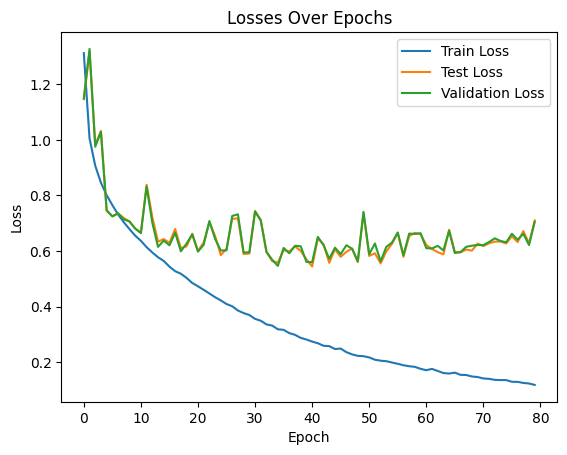

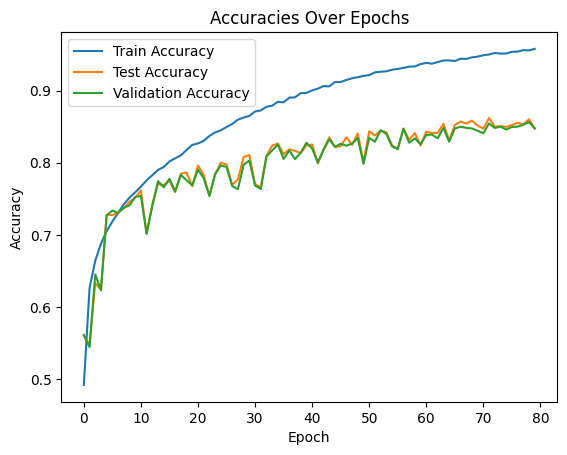

In [40]:
# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs')
plt.legend()
plt.show()

# Plot accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracies Over Epochs')
plt.legend()
plt.show()

### save model

In [41]:

model = EmotionsDetector()
torch.save(model, "C:/LMU/python/SEP_DLCV/Final_project/last_work/models/EmotionsDetector002.pth")


### parameters

In [42]:


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = torch.load(r"C:/LMU/python/SEP_DLCV/Final_project/last_work/models/EmotionsDetector002.pth")
model = model.to(device=device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 685536


### weights

In [43]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

weights = torch.load("C:/LMU/python/SEP_DLCV/Final_project/last_work/models/emotionsDetector_state_dict002.pth")

print(weights)

OrderedDict({'conv1_1.weight': tensor([[[[-0.0579,  0.0618, -0.0885],
          [ 0.2379, -0.0987,  0.1143],
          [-0.1163, -0.0592, -0.2983]],

         [[ 0.3551,  0.0757,  0.0728],
          [ 0.3251,  0.0890,  0.1938],
          [-0.1794, -0.2112, -0.1111]],

         [[ 0.1864,  0.2942,  0.3028],
          [ 0.2181,  0.2494,  0.2588],
          [ 0.0894, -0.0457,  0.1241]]],


        [[[ 0.0647, -0.3064, -0.4963],
          [ 0.5937,  0.0745, -0.3258],
          [ 0.5676,  0.2082, -0.0382]],

         [[-0.2065, -0.5661, -0.7447],
          [ 0.4333,  0.1982, -0.1940],
          [ 0.4990,  0.2797, -0.1901]],

         [[-0.0201, -0.3622, -0.6407],
          [ 0.3730,  0.1369, -0.1588],
          [ 0.7936,  0.4528, -0.2281]]],


        [[[-0.0869, -0.0020, -0.2343],
          [-0.4178, -0.5766, -0.4808],
          [-0.4986, -0.5194, -0.2147]],

         [[ 0.1248,  0.1293,  0.2100],
          [-0.0645,  0.0161, -0.1379],
          [ 0.0907,  0.0739,  0.2156]],

         [[ 0

### weights items

In [45]:
for name, param in weights.items():
  print(f"Layer Name: {name}, Shape: {param.shape}")

Layer Name: conv1_1.weight, Shape: torch.Size([48, 3, 3, 3])
Layer Name: conv1_1.bias, Shape: torch.Size([48])
Layer Name: bn1_1.weight, Shape: torch.Size([48])
Layer Name: bn1_1.bias, Shape: torch.Size([48])
Layer Name: bn1_1.running_mean, Shape: torch.Size([48])
Layer Name: bn1_1.running_var, Shape: torch.Size([48])
Layer Name: bn1_1.num_batches_tracked, Shape: torch.Size([])
Layer Name: conv1_2.weight, Shape: torch.Size([48, 48, 3, 3])
Layer Name: conv1_2.bias, Shape: torch.Size([48])
Layer Name: bn1_2.weight, Shape: torch.Size([48])
Layer Name: bn1_2.bias, Shape: torch.Size([48])
Layer Name: bn1_2.running_mean, Shape: torch.Size([48])
Layer Name: bn1_2.running_var, Shape: torch.Size([48])
Layer Name: bn1_2.num_batches_tracked, Shape: torch.Size([])
Layer Name: conv1_3.weight, Shape: torch.Size([48, 48, 3, 3])
Layer Name: conv1_3.bias, Shape: torch.Size([48])
Layer Name: bn1_3.weight, Shape: torch.Size([48])
Layer Name: bn1_3.bias, Shape: torch.Size([48])
Layer Name: bn1_3.running_m